In [145]:
import numpy as np
import os
import sys
from pprint import pprint
from numpy import sin, cos, pi
import numpy.matlib
import random
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point
import shapely.affinity as affinity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import pyomo.environ as pyo
import pyomo.gdp as pyg
from pyomo.gdp import *
from scipy.spatial import ConvexHull
#tf.disable_v2_behavior()  # this line is added to allow placeholder() function to work (does not work in tf2)

In [146]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: list index out of range

#  Generate Data


## Training/Testing Data 

#### Create Data 

In [147]:
x = np.linspace(0,4,200) 
y = np.stack([np.array([np.exp(-0.5*x[i])*np.sin(x[i]),np.exp(-0.7*x[i])*np.cos(x[i])]) + np.random.normal(0,0.005,1) for i in range(x.shape[0])],axis = 0)

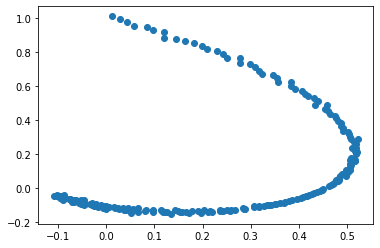

In [148]:
plt.scatter(y[:,0],y[:,1])
plt.show()

#### Safe Bound

In [149]:
poly3 = Polygon([(.45, .1), (.45, .25), (.55, .25), (.55, .1)])

# get the coordinates of the exterior points of the polytope
ex_points = np.array(poly3.exterior.coords)

# get A and b matrices: A*x <= b
hull = ConvexHull(ex_points)
eqs = np.array(hull.equations)
A = eqs[0:eqs.shape[0],0:eqs.shape[1]-1]  
b = -eqs[0:eqs.shape[0],-1]

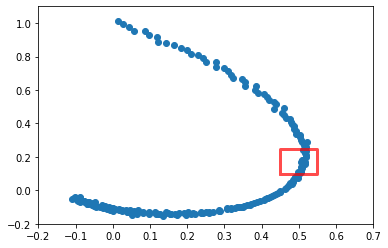

In [150]:
x_poly3, y_poly3 = poly3.exterior.xy
plt.scatter(y[:,0],y[:,1])
plt.plot(x_poly3, y_poly3, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.ylim(-.2,1.1)
plt.xlim(-.2,0.7)
plt.show()

#### Training Mini-Batch Generator

In [151]:
print(x.shape)

(200,)


In [152]:
class Batch(object):
    def __init__(self, X_col, Y_col, batch_size_val):
        self.X = X_col
        self.Y = Y_col
        self.size = X_col.shape[0]
        self.train_size = batch_size_val
        self.test_size = self.size - batch_size_val

    def getBatch(self):
        values = range(self.size)
        train_dataset, test_dataset = train_test_split(values, train_size=self.train_size, test_size=self.test_size)
        # indices = np.random.choice(range(self.size), self.batch_size)  # sampling with replacement
        return self.X[train_dataset], self.Y[train_dataset,:], self.X[test_dataset], self.Y[test_dataset,:]
num_pts = x.shape[0]
batch_size = int(0.7 * num_pts)
batch = Batch(x, y, batch_size)

# 3-Layer NN

## Build 3-Layer NN Model

Here we setup a 3-layer MLP, with the single hidden layer of ReLU activation and train it with gradient descent optimizer to learn the defined affine transformation from the given data. 
$$
\min_{\mathbf{W}^0,\mathbf{W}^1,\mathbf{W}^2,\mathbf{b}^0,\mathbf{b}^1,\mathbf{b}^2}~~\frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^0_n,\mathbf{W}^0,\mathbf{W}^1,\mathbf{b}^0,\mathbf{b}^1)-\mathbf{t}_n||^2_2
$$
$$
\mathbf{W}^0 \mathbf{x}^0 + \mathbf{b}^0 = \mathbf{h}^0
$$
$$
\mathbf{x}^1 = \mathrm{ReLU} (\mathbf{h}^0)
$$
$$
\mathbf{W}^1 \mathbf{x}^1 + \mathbf{b}^1 = \mathbf{h}^1
$$
$$
\mathbf{x}^2 = \mathrm{ReLU} (\mathbf{h}^1)
$$
$$
\mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y}
$$

#### Initializing Parameters for MLP Model

In [153]:
num_input = 1
num_output = 2
#num_layers_0 = 3
num_hidden_0 = 10
num_hidden_1 = 10
architecture = [num_input, num_hidden_0, num_hidden_1, num_output]
starter_learning_rate = 0.0005
regularizer_rate = 0.01

#Create the 3 layers model
# Define Sequential model with 3 layers
model_orig = keras.Sequential(name="3_layer_NN")
model_orig.add(layers.Dense(num_hidden_0,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            input_shape=(num_input,),
                            name="layer0"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_hidden_1,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            name="layer1"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_output,
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate), 
                            name="output"))

model_orig.summary()
print(model_orig.layers[0].weights)
print(model_orig.layers[0].kernel)

Model: "3_layer_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (Dense)               (None, 10)                20        
_________________________________________________________________
layer1 (Dense)               (None, 10)                110       
_________________________________________________________________
output (Dense)               (None, 2)                 22        
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'layer0/kernel:0' shape=(1, 10) dtype=float32, numpy=
array([[-0.22827643, -0.11425728,  0.5060862 , -0.00824934, -0.23097807,
         0.1799953 ,  0.47166055,  0.5400432 ,  0.1062488 , -0.05955684]],
      dtype=float32)>, <tf.Variable 'layer0/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]
<tf.Variable 'layer0/k

#### Train the model

In [154]:
import tensorflow.keras.backend as kb
#define costum loss function
def keras_SSE_costum(y_actual, y_predicted):
    err = y_actual - y_predicted
    loss_value = kb.sum(kb.square(err))
    return loss_value

In [155]:
# define loss 
loss = keras.losses.MeanSquaredError(name='MSE')
#loss = keras.losses.MeanSquaredLogarithmicError(name='MSLE')
optimizer = keras.optimizers.SGD(learning_rate = starter_learning_rate, name='SGD')
model_orig.compile(optimizer = optimizer,
                   loss = keras_SSE_costum,
                   metrics=['accuracy'])
x_train, y_train, x_test, y_test = batch.getBatch()

In [156]:
his = model_orig.fit(x_train, y_train, epochs=10000, use_multiprocessing = True, verbose = 0)
print("Model Accuracy on Test Data Set")
model_orig.evaluate(x_test,  y_test, verbose=2)


Model Accuracy on Test Data Set
2/2 - 0s - loss: 0.1261 - accuracy: 0.9833


[0.12607304751873016, 0.9833333492279053]

In [157]:
#w0_orig, b0_orig, w1_orig, b1_orig, w2_orig, b2_orig = s.run([weights_0, bias_0, weights_1, bias_1, weights_2, bias_2])
w0_orig = model_orig.layers[0].kernel.numpy()
b0_orig = model_orig.layers[0].bias.numpy()
w1_orig = model_orig.layers[1].kernel.numpy()
b1_orig = model_orig.layers[1].bias.numpy()
w2_orig = model_orig.layers[2].kernel.numpy()
b2_orig = model_orig.layers[2].bias.numpy()

In [158]:
weights = []
bias = []

for iterate in model_orig.layers:
    print(iterate.output_shape)
    weights.append(iterate.kernel.numpy())
    bias.append(iterate.bias.numpy())





(None, 10)
(None, 10)
(None, 2)


#### Plot Loss Function

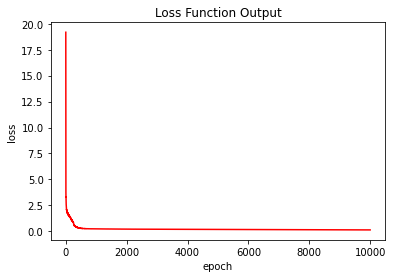

In [159]:

results_train_loss = his.history['loss']
plt.plot(results_train_loss, color='red')
plt.title('Loss Function Output')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Plot Trained Model Ouput

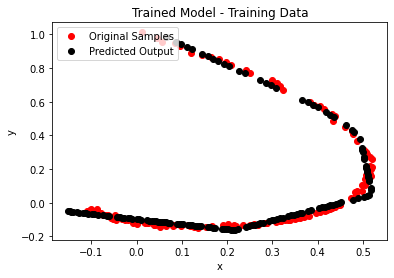

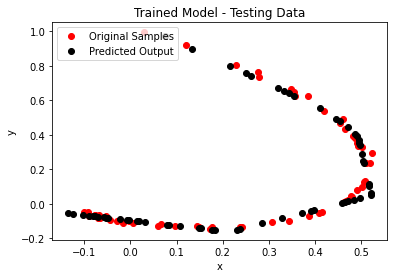

In [160]:
def plot_model(model, x_true, y_true, arg):
    y_predict = model_orig.predict(x_true)
    
    ## training output
    plt.plot(y_true[:,0], y_true[:,1], 'ro', label='Original Samples')

    ## predicted output
    plt.plot(y_predict[:,0], y_predict[:,1], 'ko', label='Predicted Output')
    plt.title(arg)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc="upper left")
    plt.show()
    return y_predict

y_predict_train = plot_model(model_orig, x_train, y_train, arg='Trained Model - Training Data')
y_predict_test = plot_model(model_orig, x_test, y_test, arg='Trained Model - Testing Data')

### Replicate the Original NN

#### Classes (NN with Numpy)

In [162]:
class Dense:
    def __init__(self, nin, nout):
        self.weights = np.random.rand(nin, nout) * 2 - 1
        self.bias = np.random.rand(nout) * 2 - 1
        
    def _relu(self, x):
        return np.maximum(x, 0)
    
    def __call__(self, x, relu=False):
        print(x.shape)
        x = x @ self.weights + self.bias
        if relu:
            x = self._relu(x)
            
        return x

    def set_variables(self, weights=None, bias=None):
        if weights is not None:
            self.weights[:] = weights[:]
            
        if bias is not None:
            self.bias[:] = bias[:]
            
class MLP:
    def __init__(self, nin, uout, uhidden):
        self.num_layer = len(uhidden)+1
        prev = nin
        self.layers = []
        for u in uhidden:
            self.layers.append(Dense(prev, u))
            prev = u
        self.layers.append(Dense(prev, uout))
        
    def __call__(self, x, relu=False):
        
        if self.num_layer == 2:
            x1 = self.layers[0](x, relu=True)
            y = self.layers[1](x1, relu=relu)
            return x1, y
        
        if self.num_layer == 3:
            x1 = self.layers[0](x, relu=True)
            x2 = self.layers[1](x1, relu=True)
            y = self.layers[2](x2, relu=relu)
            print(x.shape)
            print(x1.shape)
            print(x2.shape)
            print(y.shape)
            return x1, x2, y

#### Reconstruct the Original NN to Obtain Diferrent Layer values given Input x0

In [163]:
x_train = np.transpose(np.array([x_train]))
x_test = np.transpose(np.array([x_test]))

In [164]:
mlp_orig = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_orig.layers[0].weights=w0_orig   
mlp_orig.layers[1].weights=w1_orig  
mlp_orig.layers[2].weights=w2_orig  
mlp_orig.layers[0].bias=b0_orig
mlp_orig.layers[1].bias=b1_orig
mlp_orig.layers[2].bias=b2_orig

X0_orig_train, X1_orig_train, Y_orig_train = mlp_orig(x_train, relu=False)
X0_orig_test, X1_orig_test, Y_orig_test = mlp_orig(x_test, relu=False)

(140, 1)
(140, 10)
(140, 10)
(140, 1)
(140, 10)
(140, 10)
(140, 2)
(60, 1)
(60, 10)
(60, 10)
(60, 1)
(60, 10)
(60, 10)
(60, 2)


## Repair Class

In [165]:
class MIPLayer:
    def __init__(self, model, layer_to_repair, uin, uout, weights, bias, param_bounds=(-1, 1)):

        model.nlayers = getattr(model, 'nlayers', 0)
        # print("Model layers = {}".format(model.nlayers))
        self.layer_num = model.nlayers
        self.uin, self.uout = uin, uout

        if model.nlayers == layer_to_repair:
            w_l, b_l = 'w' + str(model.nlayers), 'b' + str(model.nlayers)
        
            setattr(model, w_l, pyo.Var(range(uin), range(uout), domain=pyo.Reals, bounds=param_bounds))
            setattr(model, b_l, pyo.Var(range(uout), domain=pyo.Reals, bounds=param_bounds))
        
            self.w = getattr(model, w_l)
            self.b = getattr(model, b_l)
            self.w_orig = weights
            self.b_orig = bias
        else:
            self.w = weights
            self.b = bias
            
        model.nlayers += 1

        self.model = model
        self.layer_to_repair = layer_to_repair
        
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1),w_b_bound_error=0.5):
        
        self.lout = getattr(self, 'layer_num', 0)+1
        if relu:
            return self._relu_constraints(x, shape, self.lout, output_bounds, w_b_bound_error)
        return self._constraints(x, shape, self.lout, output_bounds, w_b_bound_error)
    
    def _relu_constraints(self, x, shape, l, output_bounds=(-1e1, 1e1), w_b_bound_error = 0.5):
        m, n = shape
        assert n == self.uin
        
        x_l, s_l, theta_l = 'x'+str(l), 's'+str(l), 'theta'+str(l)
        w_l = 'w'+str(l-1)
        b_l = 'b'+str(l-1)

        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, s_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, theta_l, pyo.Var(range(m), range(self.uout), domain=pyo.Binary))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j] - getattr(model, s_l)[i, j]
        
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        
        if l==self.layer_to_repair+1:
            print("Activating mid layer")
            
            dw_l = 'dw' + str(l-1)
            setattr(self.model, dw_l, pyo.Var(within=pyo.NonNegativeReals, bounds=(0, output_bounds[1])))
            
            def constraint_bound_w0(model, i, j):
                return(getattr(model, w_l)[i, j]-self.w_orig[i,j] <= getattr(model, dw_l))
        
            def constraint_bound_w1(model, i, j): 
                return(getattr(model, w_l)[i, j]-self.w_orig[i,j] >= - getattr(model, dw_l))
        
            def constraint_bound_b0(model, j):
                return(getattr(model, b_l)[j]-self.b_orig[j] <= getattr(model, dw_l))
        
            def constraint_bound_b1(model, j): 
                return(getattr(model, b_l)[j]-self.b_orig[j] >= - getattr(model, dw_l))
            
            setattr(self.model, 'w_bounded_constraint0'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w0))
            setattr(self.model, 'w_bounded_constraint1'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w1))
            setattr(self.model, 'b_bounded_constraint0'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_bound_b0))
            setattr(self.model, 'b_bounded_constraint1'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_bound_b1))
        
        def disjuncts(model, i, j):
            return [(getattr(model, theta_l)[i, j] == 0, getattr(model, x_l)[i, j] <= 0),
                    (getattr(model, theta_l)[i, j] == 1, getattr(model, s_l)[i, j] <= 0)]
        
        setattr(self.model, 'disjunction'+str(l), pyg.Disjunction(range(m), range(self.uout), rule=disjuncts))
        return  getattr(self.model, x_l)
        
    def _constraints(self, x, shape, l, output_bounds=(-1e1, 1e1), w_b_bound_error = 0.5):
        m, n = shape
        assert n == self.uin
        if l==self.layer_to_repair+1:
            w_l = 'w'+str(l-1)
            b_l = 'b'+str(l-1)
        x_l = 'x'+str(l)
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.Reals, bounds=output_bounds))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j]
        
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        
        
        ########## Define the output constraint here ########################
        def constraint_inside0(model, i):  
            return [[getattr(model, x_l)[i, 0] - 0.45 <= 0],
                    [0.55 - getattr(model, x_l)[i, 0] <= 0],
                    [getattr(model, x_l)[i, 0] - 0.55 <= 0, 0.45 - getattr(model, x_l)[i, 0] <= 0, 0.25 - getattr(model, x_l)[i, 1] <= 0],
                    [getattr(model, x_l)[i, 0] - 0.55 <= 0, 0.45 - getattr(model, x_l)[i, 0] <= 0, getattr(model, x_l)[i, 1] - 0.1 <= 0]]
        
        setattr(self.model, 'keep_inside_constraint0'+str(l),
                 pyg.Disjunction(range(m), rule=constraint_inside0))
        #####################################################################

        if l==self.layer_to_repair+1:
            print("Activating Last layer")
            
            dw_l = 'dw' + str(l-1)
            setattr(self.model, dw_l, pyo.Var(within=pyo.NonNegativeReals, bounds=(0, output_bounds[1])))
            
            def constraint_bound_w0(model, i, j):
                return(getattr(model, w_l)[i, j]-self.w_orig[i,j] <= getattr(model, dw_l))
        
            def constraint_bound_w1(model, i, j): 
                return(getattr(model, w_l)[i, j]-self.w_orig[i,j] >= -getattr(model, dw_l))
        
            def constraint_bound_b0(model, j):
                return(getattr(model, b_l)[j]-self.b_orig[j] <= getattr(model, dw_l))
        
            def constraint_bound_b1(model, j): 
                return(getattr(model, b_l)[j]-self.b_orig[j] >= -getattr(model, dw_l))
            
            setattr(self.model, 'w_bounded_constraint0'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w0))
            setattr(self.model, 'w_bounded_constraint1'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w1))
            setattr(self.model, 'b_bounded_constraint0'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_bound_b0))
            setattr(self.model, 'b_bounded_constraint1'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_bound_b1))
        
        
        
        return getattr(self.model, x_l)

In [166]:
class MIPNNModel:
    def __init__(self, layer_to_repair, architecture, weights, bias, param_bounds=(-1, 1)):
        self.model = pyo.ConcreteModel()
        
        self.model.nlayers = layer_to_repair
        
        self.uin, self.uout = architecture[layer_to_repair-1], architecture[-1]
        uhidden = architecture[layer_to_repair:-1]
        
        self.layers = []
        prev = architecture[layer_to_repair-1]
        print("UHidden = {}".format(uhidden))
        for iterate, u in enumerate(uhidden): 
            self.layers.append(MIPLayer(self.model, layer_to_repair, prev, u, weights[layer_to_repair-1 + iterate], bias[layer_to_repair-1 + iterate], param_bounds))
            prev = u
        self.layers.append(MIPLayer(self.model, layer_to_repair, prev, architecture[-1], weights[-1], bias[-1], param_bounds))
        
        
    def __call__(self, x, shape, w_b_bound_error, relu=False, output_bounds=(-1e1, 1e1)):
        
        m, n = shape
        assert n == self.uin
        
        for layer in self.layers[:-1]:
            x = layer(x, (m, layer.uin), relu=True, output_bounds=output_bounds, w_b_bound_error=w_b_bound_error)
        
        layer = self.layers[-1]
        y = layer(x, (m, layer.uin), relu=relu, output_bounds=output_bounds,w_b_bound_error=w_b_bound_error)
        return y

## Repair the network with the modification of the last layer

Repairing last layer $\mathbf{W}_{new}^2 \mathbf{x}^2 + \mathbf{b}_{new}^2 = \mathbf{y}$:

\begin{align}
       & \min_{\mathbf{W}^2,\mathbf{b}^2}
       & & \frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^2_n,\mathbf{W}^2,\mathbf{b}^2)-\mathbf{t}_n||^2_2, \\
       & \text{s.t.} & &   \mathbf{W}_{new}^2 \mathbf{x}^2 + \mathbf{b}_{new}^2 = \mathbf{y},\\
       & & & \mathbf{y}\in \Psi
\end{align}


### Build 1 Layer MIP NN

#### Building 1 Layer

In [167]:
num_samples = X1_orig_train.shape[0]
layer_2_repair = 3
mip_model_layer3 = MIPNNModel(layer_2_repair, architecture, weights, bias)
y_ = mip_model_layer3(X1_orig_train, (num_samples, num_hidden_1), w_b_bound_error = 1)


model_lay3 = mip_model_layer3.model

UHidden = []
Activating Last layer


#### Define Objective function

In [168]:
def squared_sum(x, y, m, n):
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum

cost_expr = squared_sum(y_, y_train, num_samples, num_output) ## check correctness

# minimize error bound
dw_l = 'dw' + str(layer_2_repair)
cost_expr += getattr(model_lay3, dw_l)

#### Solve the OPT

In [169]:
model_lay3.obj = pyo.Objective(expr=cost_expr)
pyo.TransformationFactory('gdp.bigm').apply_to(model_lay3)
opt = pyo.SolverFactory('gurobi',solver_io="python")

opt.solve(model_lay3, tee=True)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LogFile to /var/folders/7v/7wknzt0d797gn2p62b8394yc0000gn/T/tmptoofmhot.log
   Prev:   Default: 
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1584 rows, 863 columns and 4676 nonzeros
Model fingerprint: 0x36ab9956
Model has 280 quadratic objective terms
Variable types: 303 continuous, 560 integer (560 binary)
Coefficient statistics:
  Matrix range     [4e-05, 1e+01]
  Objective range  [7e-04, 2e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e-02, 1e+01]
Found heuristic solution: objective 5483.6537570
Presolve removed 576 rows and 8 columns
Presolve time: 0.02s
Presolved: 1008 rows, 855 columns, 4084 nonzeros
Presolved model has 280 quadratic objective terms
Found heuristic solution: objective 5475.5223764
Variable types: 295 continuous, 

{'Problem': [{'Name': 'unknown', 'Lower bound': 0.19716219073884034, 'Upper bound': 0.19716219073884034, 'Number of objectives': 1, 'Number of constraints': 1584, 'Number of variables': 863, 'Number of binary variables': 560, 'Number of integer variables': 560, 'Number of continuous variables': -257, 'Number of nonzeros': 4676, 'Sense': 1, 'Number of solutions': 9}], 'Solver': [{'Name': 'Gurobi 9.12', 'Status': 'ok', 'Wallclock time': 0.40611696243286133, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [173]:
# weight error bound
model_lay3.dw3.display()

dw3 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :     0 : 0.0456258722456474 :  10.0 : False : False : NonNegativeReals


In [175]:
# model_lay3 = model_lay3_orig
y_new = np.zeros((num_samples, num_hidden_1))
w2_new = np.zeros((num_hidden_1, num_output))
b2_new = np.zeros((1, num_output))

for j in range(num_output):
    b2_new[0, j] = model_lay3.b3[j].value
    for i in range(num_hidden_1):
        w2_new[i, j] = model_lay3.w3[i, j].value
print(w2_new)
print(b2_new)


[[-0.62501825  0.69232716]
 [ 0.37776473 -0.30481091]
 [-0.51190673 -0.08801519]
 [ 0.22828174  0.86815408]
 [ 0.27669647  0.01175597]
 [ 0.36672345 -0.11270512]
 [ 0.79766739 -0.55725484]
 [ 0.3538752  -0.02915689]
 [ 0.36830512 -0.02530538]
 [-0.35937525 -0.23658922]]
[[-0.05187597  0.36069851]]


#### Build Refined NN 

In [176]:
mlp_lay3 = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_lay3.layers[0].weights=w0_orig   
mlp_lay3.layers[1].weights=w1_orig  
mlp_lay3.layers[2].weights=w2_new  
mlp_lay3.layers[0].bias=b0_orig
mlp_lay3.layers[1].bias=b1_orig
mlp_lay3.layers[2].bias=b2_new

_, _, y_new_train = mlp_lay3(x_train, relu=False)
_, _, y_new_test = mlp_lay3(x_test, relu=False)

(140, 1)
(140, 10)
(140, 10)
(140, 1)
(140, 10)
(140, 10)
(140, 2)
(60, 1)
(60, 10)
(60, 10)
(60, 1)
(60, 10)
(60, 10)
(60, 2)


#### Plot New Results

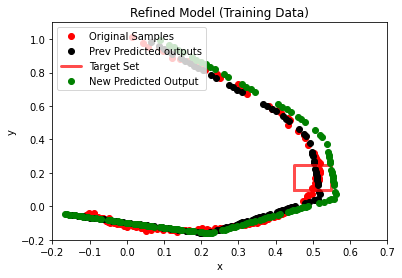

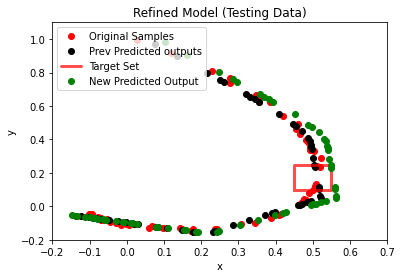

In [177]:
# ## training input
# plt.plot(x_train[:, 0], x_train[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (training)
plt.plot(y_train[:, 0], y_train[:, 1], 'ro', label='Original Samples')
plt.plot(y_predict_train[:, 0], y_predict_train[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly3, y_poly3, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.ylim(-.2,1.1)
plt.xlim(-.2,0.7)
plt.plot(y_new_train[:, 0], y_new_train[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Training Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

# ## testing input
# plt.plot(x_test[:, 0], x_test[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (testing)
plt.plot(y_test[:, 0], y_test[:, 1], 'ro', label='Original Samples')
plt.plot(y_predict_test[:, 0], y_predict_test[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly3, y_poly3, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.ylim(-.2,1.1)
plt.xlim(-.2,0.7)
plt.plot(y_new_test[:, 0], y_new_test[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Testing Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

In [178]:
MSE_original_nn_train = squared_sum(y_train, y_predict_train, num_samples, 2)/y_train.shape[0]
MSE_new_nn_train = squared_sum(y_train, y_new_train, num_samples, 2)/y_train.shape[0]
MSE_original_nn_test = squared_sum(y_test, y_predict_test, y_test.shape[0], 2)/y_test.shape[0]
MSE_new_nn_test = squared_sum(y_test, y_new_test, y_test.shape[0], 2)/y_test.shape[0]

from IPython.display import HTML, display
import tabulate
table = [["MSE","Training Data"," Testing Data"],
         ["Original NN",round(MSE_original_nn_train,5),round(MSE_original_nn_test,5)],
         ["Repaired NN (Last Layer)",round(MSE_new_nn_train,5),round(MSE_new_nn_test,5)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

weight_error = np.max(w2_new-w2_orig)
bias_error = np.max(b2_new-b2_orig)
print("weight_error: {}".format(weight_error))
print("bias_error: {}".format(bias_error))

MSE,Training Data,Testing Data
Original NN,0.00051,0.00044
Repaired NN (Last Layer),0.00108,0.00114


weight_error: 0.0456258722456474
bias_error: 0.008466115259385565


## Repair the network with the modification of the second layer

In the second layer:
$$
\mathbf{W}^1 \mathbf{X}^1 + \mathbf{b}^1 = \mathbf{H}^1,
$$
$$
\mathbf{X}^2 = \mathrm{ReLU} (\mathbf{H}^1),
$$
optimizing:

\begin{align}
       & \min_{\mathbf{W}^1,\mathbf{b}^1}
       & & \frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^1_n,\mathbf{W}^1,\mathbf{b}^1)-\mathbf{t}_n||^2_2, \\
       & \text{s.t.} & &   \mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y},\\
       & & & \mathbf{y}\in \Psi,\\
       & & & \sum_j w_{ij}^1 x_{jn}^1 + b_i^1 = x_{in}^2 - s_{in}^2, &&&&n=1,\cdots,N,~i=1,\cdots,c,~\mbox{and }j=1,\cdots,q,\\
       & & & x_{in}^2, s_{in}^2 \ge 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2 \in \{0, 1\}, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=0 \rightarrow x_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=1 \rightarrow s_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,
\end{align}
, where $N$, $c$, and $q$ are the number of samples, the number of hidden nodes, and the number of inputs, respectively.   

### Replicate the Original NN

#### Classes (NN with Numpy)

In [184]:

num_samples = X1_orig_train.shape[0]
layer_2_repair = 2
mip_model_layer2 = MIPNNModel(layer_2_repair, architecture, weights, bias)
# y_ = mip_model_layer2(X1_orig_train, (num_samples, num_hidden_1))
y_ = mip_model_layer2(np.round(X0_orig_train,4), (num_samples, num_hidden_0), w_b_bound_error=3)

# print(y_)

model_lay2 = mip_model_layer2.model





UHidden = [10]
Activating mid layer


#### Define Objective Function

In [185]:
def squared_sum(x, y, m, n):
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum

cost_expr = squared_sum(y_, np.round(y_train,4), num_samples, num_output) ## check correctness
# minimize error bound
dw_l = 'dw' + str(layer_2_repair)
cost_expr += getattr(model_lay2, dw_l)

#### Final Output and Ojbective

In [186]:
model_lay2.obj = pyo.Objective(expr=cost_expr)
pyo.TransformationFactory('gdp.bigm').apply_to(model_lay2)
opt = pyo.SolverFactory('gurobi')
opt.options['timelimit'] = 500
opt.options['mipgap'] = 0.04
opt.solve(model_lay2, tee=True)


Set parameter Username
Academic license - for non-commercial use only - expires 2022-02-04
Read LP format model from file /var/folders/7v/7wknzt0d797gn2p62b8394yc0000gn/T/tmpvfq5kkjb.pyomo.lp
Reading time = 0.03 seconds
: 12961 rows, 7952 columns, 33781 nonzeros
Set parameter TimeLimit to value 500
Set parameter MIPGap to value 0.04
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12961 rows, 7952 columns and 33781 nonzeros
Model fingerprint: 0xa8d191e8
Model has 280 quadratic objective terms
Variable types: 3192 continuous, 4760 integer (4760 binary)
Coefficient statistics:
  Matrix range     [6e-03, 1e+01]
  Objective range  [8e-04, 3e+01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [9e-05, 1e+01]
Presolve removed 7661 rows and 2851 columns
Presolve time: 0.07s
Presolved: 5300 rows, 5101 columns, 21823 nonzeros
Presolved model has 280

 26359 14363     cutoff  850         0.43306    0.01215  97.2%   168  290s
H26361 14363                       0.4330575    0.01215  97.2%   168  290s
H26388 14363                       0.4330574    0.01215  97.2%   168  290s
H26390 14363                       0.4330572    0.01215  97.2%   168  290s
H26391 14363                       0.4329932    0.01215  97.2%   168  290s
 26825 14844    0.38347   99  982    0.43299    0.01215  97.2%   168  296s
H27497 15221                       0.4329929    0.01215  97.2%   170  302s
 27678 15614    0.38347  116  848    0.43299    0.01215  97.2%   170  305s
 28619 16145    0.38347  133  832    0.43299    0.01215  97.2%   172  312s
H28630 16145                       0.4329927    0.01215  97.2%   174  312s
H28809 16145                       0.4329926    0.01215  97.2%   173  312s
 28810 16495    0.38347  141  833    0.43299    0.01215  97.2%   174  316s
 29306 16751    0.38347  144  819    0.43299    0.01215  97.2%   176  320s
H29739 16768             

{'Problem': [{'Name': '', 'Lower bound': 0.012658204154174513, 'Upper bound': 0.4317466608845742, 'Number of objectives': 1, 'Number of constraints': 12961, 'Number of variables': 7952, 'Number of binary variables': 4760, 'Number of integer variables': 4760, 'Number of continuous variables': 3192, 'Number of nonzeros': 33781, 'Sense': 'minimize'}], 'Solver': [{'Status': 'aborted', 'Return code': '0', 'Message': 'Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.', 'Termination condition': 'maxTimeLimit', 'Termination message': 'Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.', 'Wall time': '500.00932693481445', 'Error rc': 0, 'Time': 500.2802429199219}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [187]:
# weight error bound
model_lay2.dw2.display()

dw2 : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :     0 : 0.26908309989474444 :  10.0 : False : False : NonNegativeReals


In [189]:
X2_new = np.zeros((num_samples,num_output))
w1_new = np.zeros((num_hidden_0,num_hidden_1))
b1_new = np.zeros((1,num_hidden_1))
for i in range(num_samples):
    for j in range(num_output):
        X2_new[i, j] = model_lay2.x4[i, j].value
for j in range(num_hidden_1):
    b1_new[0, j] = model_lay2.b2[j].value
    for i in range(num_hidden_0):
        w1_new[i, j] = model_lay2.w2[i, j].value

#### Build Refined NN


In [190]:
mlp_lay2 = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_lay2.layers[0].weights=w0_orig   
mlp_lay2.layers[1].weights=w1_new  
mlp_lay2.layers[2].weights=w2_orig  
mlp_lay2.layers[0].bias=b0_orig
mlp_lay2.layers[1].bias=b1_new
mlp_lay2.layers[2].bias=b2_orig

_, _, y_new2_train = mlp_lay2(x_train, relu=False)
_, _, y_new2_test = mlp_lay2(x_test, relu=False)


(140, 1)
(140, 10)
(140, 10)
(140, 1)
(140, 10)
(140, 10)
(140, 2)
(60, 1)
(60, 10)
(60, 10)
(60, 1)
(60, 10)
(60, 10)
(60, 2)


#### Plot New Results


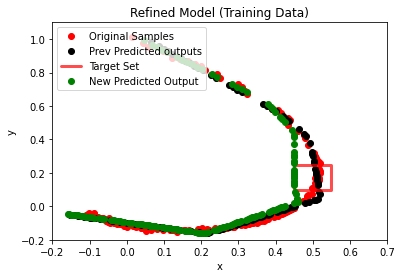

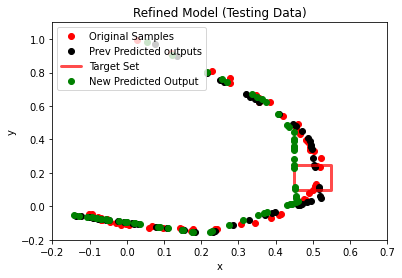

In [191]:
## predicted output (training)
plt.plot(y_train[:, 0], y_train[:, 1], 'ro', label='Original Samples')
plt.plot(y_predict_train[:, 0], y_predict_train[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly3, y_poly3, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.ylim(-.2,1.1)
plt.xlim(-.2,0.7)
plt.plot(y_new2_train[:, 0], y_new_train[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Training Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

# ## testing input
# plt.plot(x_test[:, 0], x_test[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (testing)
plt.plot(y_test[:, 0], y_test[:, 1], 'ro', label='Original Samples')
plt.plot(y_predict_test[:, 0], y_predict_test[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly3, y_poly3, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.ylim(-.2,1.1)
plt.xlim(-.2,0.7)
plt.plot(y_new2_test[:, 0], y_new_test[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Testing Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

In [192]:
MSE_original_nn_train = squared_sum(y_train, y_predict_train, num_samples, 2)/y_train.shape[0]
MSE_new_nn_train = squared_sum(y_train, y_new2_train, num_samples, 2)/y_train.shape[0]
MSE_original_nn_test = squared_sum(y_test, y_predict_test, y_test.shape[0], 2)/y_test.shape[0]
MSE_new_nn_test = squared_sum(y_test, y_new2_test, y_test.shape[0], 2)/y_test.shape[0]

from IPython.display import HTML, display
import tabulate
table = [["MSE","Training Data"," Testing Data"],
         ["Original NN",round(MSE_original_nn_train,5),round(MSE_original_nn_test,5)],
         ["Modified NN",round(MSE_new_nn_train,5),round(MSE_new_nn_test,5)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

weight_error = np.max(w1_new-w1_orig)
bias_error = np.max(b1_new-b1_orig)
print("weight_error: {}".format(weight_error))
print("bias_error: {}".format(bias_error))

MSE,Training Data,Testing Data
Original NN,0.00051,0.00044
Modified NN,0.00116,0.00114


weight_error: 0.2690830998948262
bias_error: 0.17330202093973104
